# ECG Anomaly Detection

## Project Goal

To successfully identify abnormal ECG's by training a machine learning model to recognize normal ECG's and calculate a threshold.  If the reconstruction error is below the threshold, it will be a normal heartbeat; anything above the threshold will be an anomaly.

In [ ]:
# functions that might be useful

def find_threshold(model, x_train_scaled):
  reconstructions = model.predict(x_train_scaled)
  # provides losses of individual instances
  reconstruction_errors = tf.keras.losses.mse(reconstructions, x_train_scaled)

  # threshold for anomaly scores
  threshold = np.mean(reconstruction_errors.numpy()) \
      + np.std(reconstruction_errors.numpy())
  return threshold

def find_threshold_method_two(model, x_train_scaled):
  # another method to find threshold
  reconstructions = model.predict(x_train_scaled)
  # provides losses of individual instances
  reconstruction_errors = tf.keras.losses.mse(reconstructions, x_train_scaled)

  threshold_2 = np.percentile(reconstruction_errors, 95)
  return threshold_2

def get_predictions(model, x_test_scaled, threshold):
  predictions = model.predict(x_test_scaled)
  # provides losses of individual instances
  errors = tf.keras.losses.mse(predictions, x_test_scaled)
  # 0 = anomaly, 1 = normal
  anomaly_mask = pd.Series(errors) > threshold
  preds = anomaly_mask.map(lambda x: 0.0 if x == True else 1.0)
  return preds

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredLogarithmicError

### The Dataset

From [timeseriesclassification.com...](http://www.timeseriesclassification.com/description.php?Dataset=ECG5000) The original dataset for "ECG5000" is a 20-hour long ECG downloaded from Physionet. The name is BIDMC Congestive Heart Failure Database(chfdb) and it is record "chf07". It was originally published in "Goldberger AL, Amaral LAN, Glass L, Hausdorff JM, Ivanov PCh, Mark RG, Mietus JE, Moody GB, Peng C-K, Stanley HE. PhysioBank, PhysioToolkit, and PhysioNet: Components of a New Research Resource for Complex Physiologic Signals. Circulation 101(23)". The data was pre-processed in two steps: (1) extract each heartbeat, (2) make each heartbeat equal length using interpolation. This dataset was originally used in paper "A general framework for never-ending learning from time series streams", DAMI 29(6). After that, 5,000 heartbeats were randomly selected. The patient has severe congestive heart failure and the class values were obtained by automated annotation.

In [2]:
PATH_TO_DATA = 'data/ecg.csv'
data = pd.read_csv(PATH_TO_DATA, header=None)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818287,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490658,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


You can see by scrolling to the last column that it contains the labels - 0 is an anomalous heartbeat, 1 is a normal heartbeat.

In [3]:
data.shape

(4998, 141)

### Drop target from data; create target df with labels

In [4]:
# last column is the target
# 0 = anomaly, 1 = normal

features = data.drop(140, axis=1)
target = data[140]

### Train Test Split

In [5]:
x_train, x_test, y_train, y_test = train_test_split(
    features, target, test_size=0.15, stratify=target
)

### Retain only the normal data for model training

In [6]:
# use case is novelty detection so use only the normal data for training

train_index = y_train[y_train == 1].index
train_data = x_train.loc[train_index]

### Scale the input

In [7]:
# min max scale the input data
min_max_scaler = MinMaxScaler(feature_range=(0, 1))
x_train_scaled = min_max_scaler.fit_transform(train_data.copy())
x_test_scaled = min_max_scaler.transform(x_test.copy())

### Plot a normal ECG

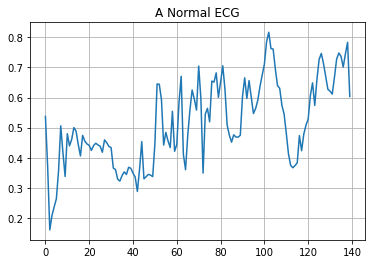

In [111]:
plt.grid()
plt.plot(np.arange(140), x_train_scaled[1])
plt.title("A Normal ECG")
plt.show()

## What is an autoencoder
    
An autoencoder is an unsupervised artificial Neural network that attempts to encode the data by compressing it into lower dimensions and the decode the data to reconstruct the original input.  The compressed representation of the input data is called the bottleneck layer.  The number of hidden units in the code is called the code size.  It has several used, one of which is for our purpose, anomaly detection.  Here's a simple diagram:

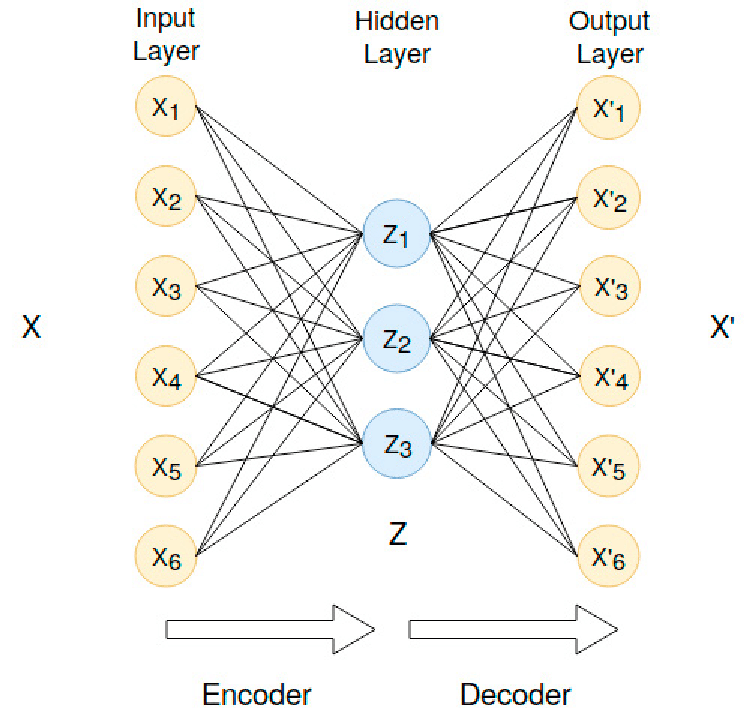



The code size, which is the size of the bottleneck, is the most important hyperperameter.  A small bottleneck lowers the risk of overfittings, but if it's too small,there is an increased chance of important information slipping out through the pooling layers of the encoder.

Autoencoding is essentially a non-linear version of Principal Component Analysis (PCA).  In fact, if the autoencoder uses only linear activations and the cost function is the mean squared error (MSE), then it ends up performing PCA.  The initial model below does exactly this:

In [230]:
encoder = Sequential([
      Dense(64),
      Dense(32)
    ])

In [231]:
decoder = Sequential([
      Dense(16),
      Dense(x_train_scaled.shape[1])
    ])

In [232]:
autoencoder = Sequential([encoder, decoder])

In [233]:
autoencoder.compile(loss='mse', optimizer='adam')

In [234]:
history = autoencoder.fit(
    x_train_scaled,
    x_train_scaled,
    epochs=20,
    batch_size=1,
    validation_data=(x_test_scaled, x_test_scaled)
)

Epoch 1/20
2481/2481 [==============================] - 2s 639us/step - loss: 0.0090 - val_loss: 0.0096
Epoch 2/20
2481/2481 [==============================] - 2s 620us/step - loss: 0.0024 - val_loss: 0.0069
Epoch 3/20
2481/2481 [==============================] - 2s 611us/step - loss: 0.0019 - val_loss: 0.0048
Epoch 4/20
2481/2481 [==============================] - 2s 611us/step - loss: 0.0017 - val_loss: 0.0043
Epoch 5/20
2481/2481 [==============================] - 2s 611us/step - loss: 0.0015 - val_loss: 0.0042
Epoch 6/20
2481/2481 [==============================] - 2s 610us/step - loss: 0.0014 - val_loss: 0.0032
Epoch 7/20
2481/2481 [==============================] - 2s 616us/step - loss: 0.0014 - val_loss: 0.0060
Epoch 8/20
2481/2481 [==============================] - 2s 609us/step - loss: 0.0013 - val_loss: 0.0058
Epoch 9/20
2481/2481 [==============================] - 2s 611us/step - loss: 0.0011 - val_loss: 0.0028
Epoch 10/20
2481/2481 [==============================] - 2s 613u

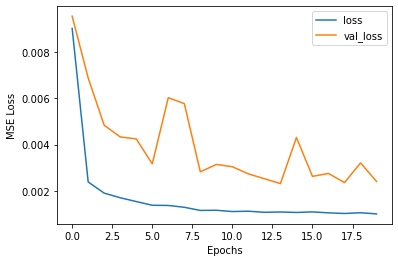

In [235]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend(['loss', 'val_loss'])
plt.show()


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



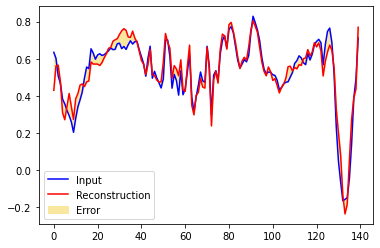

In [236]:
encoded_imgs = encoder(x_test_scaled).numpy()
decoded_imgs = decoder(encoded_imgs).numpy()

plt.plot(x_test_scaled[0],'b')
plt.plot(decoded_imgs[0],'r')
plt.fill_between(np.arange(140), decoded_imgs[0], x_test_scaled[0], color='#F9E79F' )
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

In [ ]:
reconstructions = autoencoder.predict(x_train_scaled)
train_loss = tf.keras.losses.mse(reconstructions, x_train_scaled)

plt.hist(train_loss, bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [240]:
def find_threshold(model, x_train_scaled):
  reconstructions = model.predict(x_train_scaled)
  # provides losses of individual instances
  reconstruction_errors = tf.keras.losses.msle(reconstructions, x_train_scaled)
  # threshold for anomaly scores
  threshold = np.mean(reconstruction_errors.numpy()) \
      + np.std(reconstruction_errors.numpy())
  return threshold

def get_predictions(model, x_test_scaled, threshold):
  predictions = model.predict(x_test_scaled)
  # provides losses of individual instances
  errors = tf.keras.losses.msle(predictions, x_test_scaled)
  # 0 = anomaly, 1 = normal
  anomaly_mask = pd.Series(errors) > threshold
  preds = anomaly_mask.map(lambda x: 0.0 if x == True else 1.0)
  return preds

threshold = find_threshold(autoencoder, x_train_scaled)
print(f"Threshold: {threshold}")

predictions = get_predictions(model, x_test_scaled, threshold)
accuracy_score(predictions, y_test)


Threshold: 0.0013357519740129383


0.6333333333333333

In [146]:
_, losses = predict(model, train_dataset)

sns.distplot(losses, bins=50, kde=True);

NameError: name 'predict' is not defined

In [157]:
encoder = Sequential([
      Dense(64, activation='relu'),
      Dropout(0.1),
      Dense(32, activation='relu'),
      Dropout(0.1),
      Dense(16, activation='relu'),
      Dropout(0.1),
      Dense(8, activation='relu')
    ])

In [158]:
decoder = Sequential([
      Dense(16, activation='relu'),
      Dropout(0.1),
      Dense(32, activation='relu'),
      Dropout(0.1),
      Dense(64, activation='relu'),
      Dropout(0.1),
      Dense(x_train_scaled.shape[1], activation='sigmoid')
    ])

In [159]:
autoencoder = Sequential([encoder, decoder])

In [160]:
autoencoder.compile(loss='msle', metrics=['mse'], optimizer='adam')

In [161]:
history = autoencoder.fit(
    x_train_scaled,
    x_train_scaled,
    epochs=20,
    batch_size=512,
    validation_data=(x_test_scaled, x_test_scaled)
)

Epoch 1/20
5/5 [==============================] - 0s 21ms/step - loss: 0.0111 - mse: 0.0251 - val_loss: 0.0135 - val_mse: 0.0313
Epoch 2/20
5/5 [==============================] - 0s 6ms/step - loss: 0.0106 - mse: 0.0240 - val_loss: 0.0132 - val_mse: 0.0307
Epoch 3/20
5/5 [==============================] - 0s 5ms/step - loss: 0.0098 - mse: 0.0223 - val_loss: 0.0130 - val_mse: 0.0302
Epoch 4/20
5/5 [==============================] - 0s 5ms/step - loss: 0.0089 - mse: 0.0202 - val_loss: 0.0126 - val_mse: 0.0292
Epoch 5/20
5/5 [==============================] - 0s 5ms/step - loss: 0.0079 - mse: 0.0179 - val_loss: 0.0122 - val_mse: 0.0284
Epoch 6/20
5/5 [==============================] - 0s 5ms/step - loss: 0.0070 - mse: 0.0159 - val_loss: 0.0118 - val_mse: 0.0273
Epoch 7/20
5/5 [==============================] - 0s 5ms/step - loss: 0.0062 - mse: 0.0141 - val_loss: 0.0114 - val_mse: 0.0265
Epoch 8/20
5/5 [==============================] - 0s 5ms/step - loss: 0.0057 - mse: 0.0129 - val_loss: 

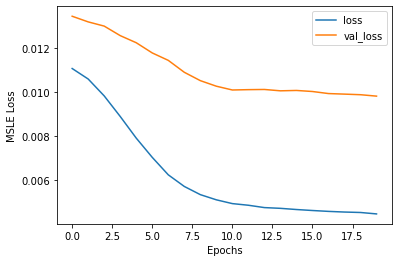

In [162]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('MSLE Loss')
plt.legend(['loss', 'val_loss'])
plt.show()

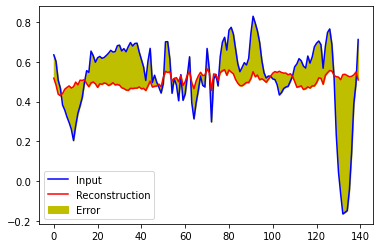

In [163]:
encoded_imgs = encoder(x_test_scaled).numpy()
decoded_imgs = decoder(encoded_imgs).numpy()

plt.plot(x_test_scaled[0],'b')
plt.plot(decoded_imgs[0],'r')
plt.fill_between(np.arange(140), decoded_imgs[0], x_test_scaled[0], color='y' )
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

In [164]:
threshold = find_threshold(autoencoder, x_train_scaled)
print(f"Threshold: {threshold}")

predictions = get_predictions(model, x_test_scaled, threshold)
accuracy_score(predictions, y_test)

Threshold: 0.009552161260815688


0.9573333333333334